# Network Traffic Analysis Pipeline

## 0. Setup Environment

0.1. Install all needed dependencies


In [ ]:
%pip install pyshark
%pip install nest_asyncio
%pip install pandas
%pip install pymongo
%pip install python-dotenv
%pip install scikit-learn
%pip install matplotlib
%pip install river

0.2. Allow the notebook to work assynchronously.

In [1]:
import nest_asyncio
nest_asyncio.apply()

0.3. Setup global variables

In [2]:
import time
import sys
sys.path.append('..')
run_seed=int(time.time())
base_training_percentage = 60
online_training_percentage = 20
validation_percentage = 20

## 1. Data Gathering

1.1. Download datasets

1.2. Store datasets in a local folder

1.3. Select and label the datasets.
For each dataset, add it to the list of datasets in a tuple with the format `(dataset_path, dataset_label)`, where:
- `dataset_path` is the path to the dataset file
- `dataset_label` is the label that should be assigned to the entries, this can be either `normal`,`anomaly` or `unknown`(for unsupervised training)

In [ ]:
dataset_files = []

## 2. Data Preprocessing

2.1. Import the desired preprocessor.

In [3]:
from src.preprocessors.pcap_preprocessor import PcapPreprocessor

preprocessor = PcapPreprocessor()

2.2. Load and preprocess the datasets.

    This step may depend on the preprocessor used. 
    The preprocessor should store the data and preprocess the data, providing methods to access it.
    In the case of classes that don't store the data in memory, this step can be skipped after the first execution. 


In [ ]:
if len(dataset_files) > 0:
    preprocessor.load_datasets(dataset_files)

## 3. Data Visualization

3.1. Gather all the data in a single dataframe for visualization.

In [4]:
import pandas as pd
all_data = preprocessor.get_all_data()
all_data = preprocessor.preprocess_dataframe(all_data)

3.X. Add vizualization steps here

In [ ]:
print(all_data.info())
for col in all_data.columns: 
    print(col)

## 4. Model Training

4.1. Select and import the desired models.

In [5]:
from src.models.offline.offlineRandomForest import Offline_RandomForest
from src.models.offline.offlineDecisionTree import Offline_DecisionTree
from src.models.offline.offlineSVM import Offline_SVM
from src.models.online.onlineSGDClassifierHinge import Online_SGDClassifierHinge
from src.models.online.onlineSGDClassifierLogLoss import Online_SGDClassifierLogLoss
from src.models.online.onlineBaggingClassifier import Online_BaggingClassifier


model_list = [Offline_RandomForest(), Offline_DecisionTree(), Offline_SVM(), Online_SGDClassifierHinge(), Online_SGDClassifierLogLoss(), Online_BaggingClassifier()]

4.2. Gather the data for training.

When training online models a second dataframe is provided to simulate the online training.z

In [6]:
training_data,online_training_data = preprocessor.get_training_data(base_training_percentage, online_training_percentage, True, seed=run_seed)

print(training_data.info())
print(online_training_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Columns: 1472 entries, _id to dhcpv6.requested_option_code
dtypes: float64(795), object(677)
memory usage: 1.3+ GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Columns: 1328 entries, _id to tls.resumed
dtypes: float64(700), object(628)
memory usage: 385.0+ MB
None


4.3. Train the models using the offline data.

In [7]:
for model in model_list:
    print("Training model " + model.get_name())
    model.train(training_data)

Training online model OfflineRF
Training online model OfflineDT
Training online model OfflineSVM
Training online model OnlineSGDHinge
Training online model OnlineSGDLogLoss
Training online model OnlineBagging


4.4. Train the online models simulating an online enviorment.

In [8]:
for model in model_list:
    if model.is_online():
        print("Training online model " + model.get_name())
        for index, row in online_training_data.iterrows():
            model.predict(row)

Training online model OnlineSGDHinge
Training online model OnlineSGDLogLoss
Training online model OnlineBagging


## 5. Model Evaluation

5.1. Select and import the desired evaluator.

In [9]:
from src.evaluators.standard_evaluator import Evaluator

evaluator = Evaluator()

5.2. Gather the data for evaluation.

In [10]:
validation_data = preprocessor.get_validation_data(validation_percentage,seed=run_seed)

5.3. Get the predictions from all models into a dataframe.

In [11]:
# Header
header = ['expected']
for model in model_list:
    header.append(model.id)
validation_results = [header]

# Results
labels = validation_data['label']
validation_data = validation_data.drop(columns=['label'])
model_results = []
for model in model_list:
    model_results.append(model.predict_batch(validation_data))

for i in range(len(labels)):
    row = [labels[i]]
    for model_result in model_results:
        row.append(model_result[i])
    validation_results.append(row)

df = pd.DataFrame(validation_results)
print(df)

              0                     1                     2  \
0      expected  OfflineRF_1732192132  OfflineDT_1732192132   
1        normal                normal                normal   
2        normal                normal                normal   
3        normal                normal                normal   
4        normal                normal                normal   
...         ...                   ...                   ...   
37996    normal                normal                normal   
37997    normal                normal                normal   
37998    normal                normal                normal   
37999    normal                normal                normal   
38000    normal                normal                normal   

                           3                          4  \
0      OfflineSVM_1732192132  OnlineSGDHinge_1732192132   
1                     normal                     normal   
2                     normal                     normal   
3      

5.4. Evaluate the models using their predictions.

In [12]:
results = evaluator.evaluate(df)

5.5. Analyze the results.

In [13]:
print(results)

                          model  accuracy  precision    recall  f1_score
0          OfflineRF_1732192132  0.965000   0.981815  0.943235  0.962138
1          OfflineDT_1732192132  0.908368   0.992091  0.812123  0.893131
2         OfflineSVM_1732192132  0.968026   0.936627  0.999833  0.967199
3     OnlineSGDHinge_1732192132  0.957763   0.926253  0.989172  0.956679
4  OnlineSGDCLogLoss_1732192132  0.461684   0.466187  0.977339  0.631264
5      OnlineBagging_1732192132  0.893895   0.816293  1.000000  0.898856


/home/ritavaz02/.local/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ritavaz02/.local/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ritavaz02/.local/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/ritavaz02/.local/lib/python3.11/site-pac

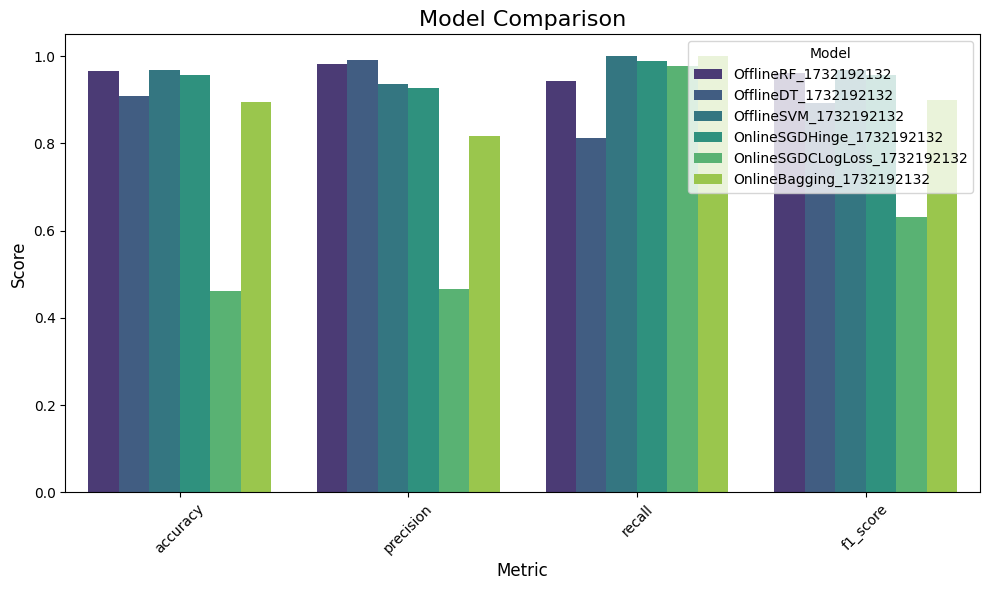

In [14]:
evaluator.model_comparison(results)

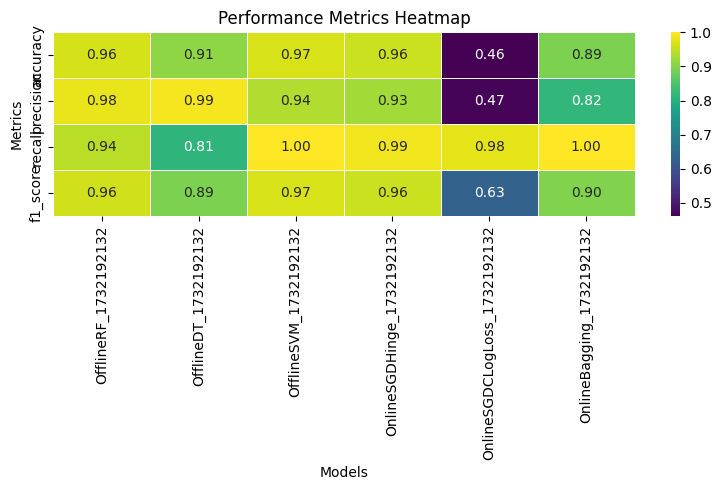

In [15]:
evaluator.heatmap_performance_metrics(results)

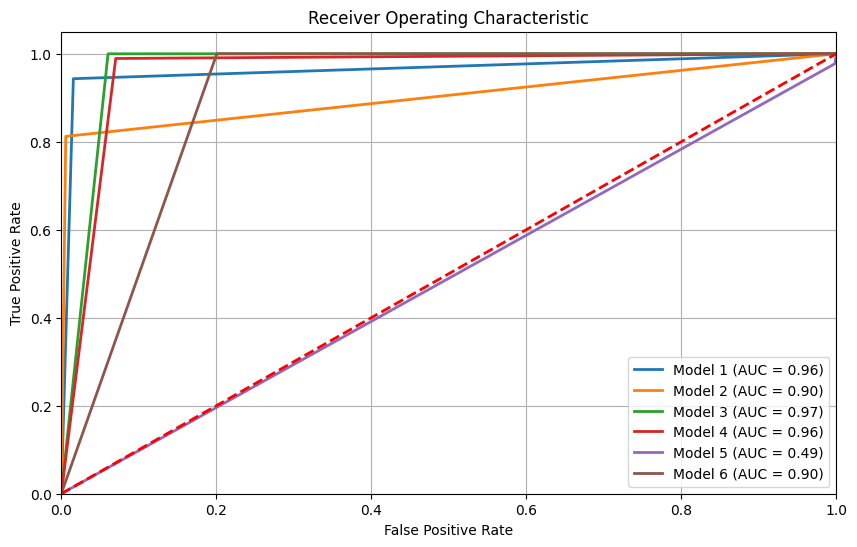

In [16]:
evaluator.roc_curve_per_model(df)